# Python Notebook to train the GNN on COVINO data
Here, a message passing GNN(graph neural net) is trained on graphs representing a frame of an MD simulation. Each frame has a target value that represents the probability of a conformation target.

In [1]:
##IMPORTS
import os
import numpy as np
import matplotlib.pyplot as plt

import time

from torch.utils.tensorboard import SummaryWriter

import torch
from torch_geometric.data import Data, Batch, DataLoader

from torch.nn import Sequential as Seq, Linear as Lin, LeakyReLU, BatchNorm1d, Sigmoid
from torch_scatter import scatter_mean, scatter_add
from torch_geometric.nn import MetaLayer

# Load graph data into list and scale graph data
Data is from "2_raw_graph", produced by "1_MAKE_GRAPH_FROM_H5"

In [2]:
#Set up a definition to scale graph data - TODO!!
def scale_graph_data(graph):
    graph.x = (graph.x-torch.mean(graph.x, dim=0))/torch.std(graph.x)
    graph.edge_attr = (graph.edge_attr-torch.mean(graph.edge_attr, dim=0))/torch.std(graph.edge_attr)
    return graph

In [3]:
#Set up list where graphs are stored
list_of_graphs = []

#Load graphs into list
loc_file = "2_raw_graphs/"


start_load = time.time()
#Loading the graphs
#for gr in os.listdir(loc_file)[:5]+os.listdir(loc_file)[-5:]: #Just take the first 100 frames as a quick tryout to save RAM
for gr in os.listdir(loc_file)[::100]:
    data = torch.load(loc_file+gr)
    #data_sc = scale_graph_data(data)
    list_of_graphs.append(data)
print("Load Time: {}s".format(np.around(time.time()-start_load,2)))

TT_SPLIT = 0.8
training_data = list_of_graphs[:int(len(list_of_graphs)*TT_SPLIT)]
testing_data = list_of_graphs[int(len(list_of_graphs)*TT_SPLIT):]

Load Time: 0.12s


# Set up Graph net blocks - edge, node, global - without Encoding!
Edge, Node and Global models for the MetaLayer \
In general without BatchNorm (but possible), \
0/1 Hidden Layer, \
LeakyRelu activation \
Glorot uniform initialization

In [4]:
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

class EdgeModel(torch.nn.Module):
    def __init__(self):
        super(EdgeModel, self).__init__()
        hidden = HIDDEN_EDGE
        in_channels = EDGE_FEATURES+2*NODE_FEATURES
        self.edge_mlp = Seq(Lin(in_channels, hidden), LeakyReLU(),# BatchNorm1d(hidden),
                            Lin(hidden, EDGE_FEATURES)).apply(init_weights)

    def forward(self, src, dest, edge_attr, u, batch):
        # source, target: [E, F_x], where E is the number of edges.
        # edge_attr: [E, F_e]
        # u: [B, F_u], where B is the number of graphs.
        # batch: [E] with max entry B - 1.
        out = torch.cat([src, dest, edge_attr], 1)
        return self.edge_mlp(out)

class NodeModel(torch.nn.Module):
    def __init__(self):
        super(NodeModel, self).__init__()
        hidden=HIDDEN_NODE
        in_channels_1 = EDGE_FEATURES+NODE_FEATURES
        in_channels_2 = hidden+NODE_FEATURES
        self.node_mlp_1 = Seq(Lin(in_channels_1, hidden), LeakyReLU(),# BatchNorm1d(hidden),
                              Lin(hidden, hidden)).apply(init_weights)
        self.node_mlp_2 = Seq(Lin(in_channels_2, hidden), LeakyReLU(),# BatchNorm1d(hidden),
                              Lin(hidden, NODE_FEATURES)).apply(init_weights)

    def forward(self, x, edge_index, edge_attr, u, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        row, col = edge_index
        out = torch.cat([x[row], edge_attr], dim=1)
        out = self.node_mlp_1(out)
        out = scatter_add(out, col, dim=0, dim_size=x.size(0))
        out = torch.cat([x, out], dim=1)
        return self.node_mlp_2(out)

class GlobalModel(torch.nn.Module):
    def __init__(self):
        super(GlobalModel, self).__init__()
        hidden = HIDDEN_GLOBAL
        in_channels=NODE_FEATURES+EDGE_FEATURES

        self.global_mlp = Seq(Lin(in_channels, hidden), LeakyReLU(),# BatchNorm1d(hidden),
                              Lin(hidden, GLOBAL_FEATURES)).apply(init_weights)

    def forward(self, x, edge_index, edge_attr, u, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        row,col=edge_index
        node_aggregate = scatter_add(x, batch, dim=0)
        edge_aggregate = scatter_add(edge_attr, batch[col], dim=0)
        out = torch.cat([node_aggregate, edge_aggregate], dim=1)
        return self.global_mlp(out)

# Set up Graph net blocks - edge, node, global - WITH Encoding!
Edge, Node and Global models for the MetaLayer \
In general without BatchNorm (but possible), \
0/1 Hidden Layer, \
LeakyRelu activation \
Glorot uniform initialization

In [5]:
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

class EdgeModel_ENC(torch.nn.Module):
    def __init__(self):
        super(EdgeModel_ENC, self).__init__()
        hidden = HIDDEN_EDGE
        in_channels = ENCODING_SIZE+2*ENCODING_SIZE
        self.edge_mlp = Seq(Lin(in_channels, hidden), LeakyReLU(),# BatchNorm1d(hidden),
                            Lin(hidden, ENCODING_SIZE)).apply(init_weights)

    def forward(self, src, dest, edge_attr, u, batch):
        # source, target: [E, F_x], where E is the number of edges.
        # edge_attr: [E, F_e]
        # u: [B, F_u], where B is the number of graphs.
        # batch: [E] with max entry B - 1.
        out = torch.cat([src, dest, edge_attr], 1)
        return self.edge_mlp(out)

class NodeModel_ENC(torch.nn.Module):
    def __init__(self):
        super(NodeModel_ENC, self).__init__()
        hidden=HIDDEN_NODE
        in_channels_1 = ENCODING_SIZE+ENCODING_SIZE
        in_channels_2 = hidden+ENCODING_SIZE
        self.node_mlp_1 = Seq(Lin(in_channels_1, hidden), LeakyReLU(),# BatchNorm1d(hidden),
                              Lin(hidden, hidden)).apply(init_weights)
        self.node_mlp_2 = Seq(Lin(in_channels_2, hidden), LeakyReLU(),# BatchNorm1d(hidden),
                              Lin(hidden, ENCODING_SIZE)).apply(init_weights)

    def forward(self, x, edge_index, edge_attr, u, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        row, col = edge_index
        out = torch.cat([x[row], edge_attr], dim=1)
        out = self.node_mlp_1(out)
        out = scatter_add(out, col, dim=0, dim_size=x.size(0))
        out = torch.cat([x, out], dim=1)
        return self.node_mlp_2(out)

class GlobalModel_ENC(torch.nn.Module):
    def __init__(self):
        super(GlobalModel_ENC, self).__init__()
        hidden = HIDDEN_GLOBAL
        in_channels=ENCODING_SIZE+ENCODING_SIZE

        self.global_mlp = Seq(Lin(in_channels, hidden), LeakyReLU(),# BatchNorm1d(hidden),
                              Lin(hidden, GLOBAL_FEATURES)).apply(init_weights)

    def forward(self, x, edge_index, edge_attr, u, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        row,col=edge_index
        node_aggregate = scatter_add(x, batch, dim=0)
        edge_aggregate = scatter_add(edge_attr, batch[col], dim=0)
        out = torch.cat([node_aggregate, edge_aggregate], dim=1)
        #out = torch.cat([node_aggregate], dim=1)
        return self.global_mlp(out)

# Set up GNN model - GNNCP
This GNN model takes input graphs of each frame, and predicts the conformation probability as output.

In [6]:
class GNNCP(torch.nn.Module):
    def __init__(self):
        super(GNNCP, self).__init__()
        
        #Define constants for network
        self.batch_size = BATCH_SIZE
        self.global_feats = GLOBAL_FEATURES
        self.no_mp = NO_MP
        
        self.mlp_hidden = MLP_HIDDEN
        self.targ_size = TARG_SIZE
        
        #Define MP layer - MetaLayer Class
        self.meta = MetaLayer(EdgeModel(), NodeModel(), GlobalModel())

        #Define last stage MLP that makes prediction from global
        self.mlp = Seq(Lin(self.global_feats, self.mlp_hidden), LeakyReLU(), #BatchNorm1d(self.mlp_hidden), 
                       Lin(self.mlp_hidden, self.mlp_hidden), LeakyReLU(), #BatchNorm1d(self.mlp_hidden), 
                       Lin(self.mlp_hidden, self.targ_size)).apply(init_weights)
    
    def forward(self, g):
        #Extract tensors from input graph
        x, ea, ei, btc = g.x, g.edge_attr, g.edge_index, g.batch
        
        #Set up global attribute vector for message passing
        #careful: has to be dtype torch float 32, and be manually passed to device in case of GPU
        u = torch.full(size=(self.batch_size, self.global_feats), fill_value = 1, dtype=torch.float).to(device)
        
        #Perform the message passing rounds
        for _ in range(self.no_mp):
            x, ea, u = self.meta(x=x, edge_attr=ea, edge_index=ei, u=u, batch=btc)
        
        #Run the obtained embedding/global frame features through the MLP to obtain final prediction
        c = self.mlp(u)
        
        return c

# Set up GNN model - GNNCP_ENC (WITH ENCODING!)
This GNN model takes input graphs of each frame, and predicts the conformation probability as output.

In [7]:
class GNNCP_ENC(torch.nn.Module):
    def __init__(self):
        super(GNNCP_ENC, self).__init__()
        
        #Define constants for network
        self.batch_size = BATCH_SIZE
        self.global_feats = GLOBAL_FEATURES
        self.no_mp = NO_MP
        
        self.mlp_hidden = MLP_HIDDEN
        self.targ_size = TARG_SIZE
        
        self.encoding = ENCODING_SIZE
        
        #Define MP layer - MetaLayer Class
        self.meta = MetaLayer(EdgeModel_ENC(), NodeModel_ENC(), GlobalModel_ENC())
        
        #Define Encoding MLPs
        self.edge_encoding = Seq(Lin(EDGE_FEATURES, self.encoding), LeakyReLU(),
                                 Lin(self.encoding, self.encoding)).apply(init_weights)
        self.node_encoding = Seq(Lin(NODE_FEATURES, self.encoding), LeakyReLU(),
                                 Lin(self.encoding, self.encoding)).apply(init_weights)
        
        #Define last stage MLP that makes prediction from global
        self.mlp = Seq(Lin(self.global_feats, self.mlp_hidden), LeakyReLU(), #BatchNorm1d(self.mlp_hidden), 
                       Lin(self.mlp_hidden, self.mlp_hidden), LeakyReLU(), #BatchNorm1d(self.mlp_hidden), 
                       Lin(self.mlp_hidden, self.targ_size)).apply(init_weights)
    
    def forward(self, g):
        #Extract tensors from input graph
        x, ea, ei, btc = g.x, g.edge_attr, g.edge_index, g.batch
        
        #Encode nodes and edges
        x = self.node_encoding(x)
        ea = self.edge_encoding(ea)
        
        #Set up global attribute vector for message passing
        #careful: has to be dtype torch float 32, and be manually passed to device in case of GPU
        u = torch.full(size=(self.batch_size, self.global_feats), fill_value = 1, dtype=torch.float).to(device)
        
        #Perform the message passing rounds
        for _ in range(self.no_mp):
            x, ea, u = self.meta(x=x, edge_attr=ea, edge_index=ei, u=u, batch=btc)
        
        #Run the obtained embedding/global frame features through the MLP to obtain final prediction
        c = self.mlp(u)
        
        return c

# Set up model parameters and instantiate the GNNCP model

In [8]:
#Get no. of node and edge features from graphs, as well as target size
NODE_FEATURES = list_of_graphs[0].x.size()[1]
EDGE_FEATURES = list_of_graphs[0].edge_attr.size()[1]
TARG_SIZE = list_of_graphs[0].y.size()[0]

ENCODING_SIZE = 16

#Set up features
HIDDEN_EDGE=16
HIDDEN_NODE=16
HIDDEN_GLOBAL=16

MLP_HIDDEN = 512

GLOBAL_FEATURES = 2048
NO_MP = 1
BATCH_SIZE = 2

# --------- Get device to run this on
gpu = 0
device = torch.device(f"cuda:{gpu}" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(device)
print(f"DEVICE: {device}")

#Instantiate model
#model = GNNCP().to(device)
model = GNNCP_ENC().to(device)

DEVICE: cuda:0


In [9]:
model

GNNCP_ENC(
  (meta): MetaLayer(
      edge_model=EdgeModel_ENC(
    (edge_mlp): Sequential(
      (0): Linear(in_features=48, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=16, bias=True)
    )
  ),
      node_model=NodeModel_ENC(
    (node_mlp_1): Sequential(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=16, bias=True)
    )
    (node_mlp_2): Sequential(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=16, bias=True)
    )
  ),
      global_model=GlobalModel_ENC(
    (global_mlp): Sequential(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=2048, bias=True)
    )
  )
  )
  (edge_encoding): Sequential(
    (0): Li

# Define training function and training parameters, and evaluation function

## Training parameters

In [10]:
LEARNING_RATE = 0.0001
EPOCHS = 2000
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
#criterion = binomial
#criterion = torch.nn.MSELoss()
#criterion = torch.nn.BCEWithLogitsLoss()
mae_loss = torch.nn.L1Loss(reduction="mean")

#Register backward hook for gradient clipping
clip_value = 0.1
for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))

writer = SummaryWriter('runs/GNNCP_MP_'+str(NO_MP)+"_"+str(EPOCHS)+"_epochs"+"_"+str([i for i in time.gmtime()[0:6]]))

train_loader = DataLoader(training_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(testing_data, batch_size=BATCH_SIZE)

## Custom loss function - Binomial Loss

In [11]:
def binomial_loss(targ, out, reduce):
    term1 = torch.unsqueeze(targ[:,0], dim=1)*torch.log(1+torch.exp(out/reduce))
    term1_fix = torch.where(torch.isinf(term1).to(device), torch.tensor([0.]).to(device), term1.to(device))
    
    term2 = torch.unsqueeze(targ[:,1], dim=1)*torch.log(1+torch.exp(-out/reduce))
    term2_fix = torch.where(torch.isinf(term2).to(device), torch.tensor([0.]).to(device), term2.to(device))
    
    bin_loss = term1_fix + term2_fix
    bin_loss = torch.sum(bin_loss)
    return bin_loss

# Sanity check

In [12]:
#btc=next(iter(train_loader))
#out = model(btc.to(device))
#out

In [13]:
#torch.exp(out/1000000)

In [14]:
#1+torch.exp(out)

In [15]:
#binomial_loss(btc.y.to(device),out)

## Training function

In [16]:
def train(reduce):
    loss_avg=[]
    for btc_data in train_loader:
        #Get target from batch
        targ = btc_data.to(device).y
        #Forward pass through model
        out = model(btc_data.to(device)).T

        #loss = criterion(out[0], targ)
        loss = binomial_loss(targ, out, reduce)
        
        #zero the gradient
        optimizer.zero_grad()
        
        #Backward pass
        loss.backward()
        optimizer.step()
        
        loss_avg.append(loss.item())
        
        #Empty CUDA cache
        torch.cuda.empty_cache()
    
    return np.mean(loss_avg)
        

## Evaluation function

In [17]:
def evaluate(loader, reduce):
    error_avg=[]
    with torch.no_grad():
        for btc_data in loader:
            #Get target from batch and send as numpy to cpu
            targ = btc_data.y.detach().cpu()
            #Forward pass through model
            out = model(btc_data.to(device)).T.detach().cpu()
            
            #Calculate error
            #error = mae_loss(out[0], targ)
            error = binomial_loss(targ, out, reduce)
            error_avg.append(error.item())
            
            #Empty CUDA cache
            torch.cuda.empty_cache()
    return np.mean(error_avg)

# DOING THE DEED (training)

In [18]:
losses = []
train_err_list = []
test_err_list = []

model.train()
TIME=time.time()
reduce=1000000

for epoch in range(1,EPOCHS+1):
    #model.train()
    loss = train(reduce)
    print("{}/{} Loss: {}, Time:{}s".format(epoch,EPOCHS,loss,np.around(time.time()-TIME,2)))
    TIME=time.time()
    #model.eval()
    train_err = evaluate(train_loader,reduce)
    test_err = evaluate(test_loader, reduce)
    
    writer.add_scalar("loss",loss,epoch)
    writer.add_scalar("train_err",train_err,epoch)
    writer.add_scalar("test_err",test_err,epoch)
    
    losses.append(loss)
    train_err_list.append(train_err)
    test_err_list.append(test_err)

1/2000 Loss: 1594.4850158691406, Time:1.2s
2/2000 Loss: 1611.8314819335938, Time:1.3s
3/2000 Loss: 1639.1676330566406, Time:1.29s
4/2000 Loss: 1594.778076171875, Time:1.3s
5/2000 Loss: 1574.8453369140625, Time:1.3s
6/2000 Loss: 1566.251708984375, Time:1.3s
7/2000 Loss: 1563.5913696289062, Time:1.3s
8/2000 Loss: 1562.862548828125, Time:1.3s
9/2000 Loss: 1563.4271240234375, Time:1.3s
10/2000 Loss: 1564.0086975097656, Time:1.51s
11/2000 Loss: 1564.1086730957031, Time:1.39s
12/2000 Loss: 1564.1505126953125, Time:1.31s
13/2000 Loss: 1564.170166015625, Time:1.3s
14/2000 Loss: 1564.2862854003906, Time:1.3s
15/2000 Loss: 1564.5328674316406, Time:1.36s
16/2000 Loss: 1564.7257995605469, Time:1.48s
17/2000 Loss: 1564.7633666992188, Time:1.35s
18/2000 Loss: 1564.7503356933594, Time:1.44s
19/2000 Loss: 1564.5555114746094, Time:1.35s
20/2000 Loss: 1564.4143371582031, Time:1.34s
21/2000 Loss: 1564.3034973144531, Time:1.34s
22/2000 Loss: 1564.1260681152344, Time:1.34s
23/2000 Loss: 1564.2337951660156,

184/2000 Loss: 1554.1674499511719, Time:1.35s
185/2000 Loss: 1554.0817565917969, Time:1.32s
186/2000 Loss: 1553.9241333007812, Time:1.31s
187/2000 Loss: 1553.7008972167969, Time:1.33s
188/2000 Loss: 1553.4413757324219, Time:1.34s
189/2000 Loss: 1553.1502990722656, Time:1.34s
190/2000 Loss: 1552.9265747070312, Time:1.31s
191/2000 Loss: 1552.7001037597656, Time:1.3s
192/2000 Loss: 1552.6172180175781, Time:1.3s
193/2000 Loss: 1552.5857849121094, Time:1.31s
194/2000 Loss: 1552.5322265625, Time:1.31s
195/2000 Loss: 1552.4793701171875, Time:1.3s
196/2000 Loss: 1552.4078674316406, Time:1.3s
197/2000 Loss: 1552.3325805664062, Time:1.31s
198/2000 Loss: 1552.2559814453125, Time:1.31s
199/2000 Loss: 1552.2378540039062, Time:1.3s
200/2000 Loss: 1552.2151794433594, Time:1.3s
201/2000 Loss: 1552.107177734375, Time:1.37s
202/2000 Loss: 1552.0025634765625, Time:1.55s
203/2000 Loss: 1551.8934631347656, Time:1.35s
204/2000 Loss: 1551.8396911621094, Time:1.36s
205/2000 Loss: 1551.7563171386719, Time:1.37

364/2000 Loss: 1541.3724365234375, Time:1.4s
365/2000 Loss: 1541.3853759765625, Time:1.3s
366/2000 Loss: 1541.3843383789062, Time:1.31s
367/2000 Loss: 1541.3648681640625, Time:1.3s
368/2000 Loss: 1541.3355407714844, Time:1.31s
369/2000 Loss: 1541.3090209960938, Time:1.31s
370/2000 Loss: 1541.2988586425781, Time:1.31s
371/2000 Loss: 1541.2864990234375, Time:1.31s
372/2000 Loss: 1541.271240234375, Time:1.31s
373/2000 Loss: 1541.2587585449219, Time:1.32s
374/2000 Loss: 1541.2664184570312, Time:1.32s
375/2000 Loss: 1541.2706909179688, Time:1.32s
376/2000 Loss: 1541.2637023925781, Time:1.33s
377/2000 Loss: 1541.29833984375, Time:1.33s
378/2000 Loss: 1541.2907409667969, Time:1.34s
379/2000 Loss: 1541.2430419921875, Time:1.56s
380/2000 Loss: 1541.239501953125, Time:1.34s
381/2000 Loss: 1541.2597045898438, Time:1.31s
382/2000 Loss: 1541.2816772460938, Time:1.31s
383/2000 Loss: 1541.2854309082031, Time:1.34s
384/2000 Loss: 1541.2440185546875, Time:1.31s
385/2000 Loss: 1541.1870727539062, Time:1

544/2000 Loss: 1553.3598327636719, Time:1.38s
545/2000 Loss: 1546.2137451171875, Time:1.37s
546/2000 Loss: 1541.8599548339844, Time:1.44s
547/2000 Loss: 1542.384765625, Time:1.33s
548/2000 Loss: 1545.5750732421875, Time:1.3s
549/2000 Loss: 1541.4854125976562, Time:1.42s
550/2000 Loss: 1551.3176574707031, Time:1.32s
551/2000 Loss: 1541.3783874511719, Time:1.42s
552/2000 Loss: 1542.1252746582031, Time:1.46s
553/2000 Loss: 1550.5324096679688, Time:1.46s
554/2000 Loss: 1540.5959777832031, Time:1.54s
555/2000 Loss: 1543.8924560546875, Time:1.32s
556/2000 Loss: 1552.8282775878906, Time:1.34s
557/2000 Loss: 1542.1226196289062, Time:1.32s
558/2000 Loss: 1541.3035278320312, Time:1.32s
559/2000 Loss: 1545.76611328125, Time:1.39s
560/2000 Loss: 1541.1536560058594, Time:1.34s
561/2000 Loss: 1549.7939758300781, Time:1.34s
562/2000 Loss: 1542.0189819335938, Time:1.41s
563/2000 Loss: 1541.4309387207031, Time:1.32s
564/2000 Loss: 1543.5367736816406, Time:1.32s
565/2000 Loss: 1543.9534606933594, Time:1

724/2000 Loss: 1542.7972717285156, Time:1.44s
725/2000 Loss: 1542.5326232910156, Time:1.39s
726/2000 Loss: 1542.0955505371094, Time:1.37s
727/2000 Loss: 1542.7848815917969, Time:1.38s
728/2000 Loss: 1542.4137573242188, Time:1.38s
729/2000 Loss: 1542.6904907226562, Time:1.4s
730/2000 Loss: 1542.653076171875, Time:1.39s
731/2000 Loss: 1542.4156188964844, Time:1.4s
732/2000 Loss: 1542.6261291503906, Time:1.38s
733/2000 Loss: 1542.7329406738281, Time:1.38s
734/2000 Loss: 1542.6493530273438, Time:1.38s
735/2000 Loss: 1542.5679931640625, Time:1.37s
736/2000 Loss: 1542.9137268066406, Time:1.39s
737/2000 Loss: 1542.6365051269531, Time:1.46s
738/2000 Loss: 1542.7265014648438, Time:1.49s
739/2000 Loss: 1542.7030639648438, Time:1.52s
740/2000 Loss: 1542.8128662109375, Time:1.4s
741/2000 Loss: 1542.5689392089844, Time:1.41s
742/2000 Loss: 1542.89990234375, Time:1.45s
743/2000 Loss: 1542.5589294433594, Time:1.43s
744/2000 Loss: 1543.2701110839844, Time:1.4s
745/2000 Loss: 1542.3750305175781, Time:1

904/2000 Loss: 1542.3851623535156, Time:1.34s
905/2000 Loss: 1543.1076354980469, Time:1.35s
906/2000 Loss: 1550.5991516113281, Time:1.35s
907/2000 Loss: 1569.5257568359375, Time:1.33s
908/2000 Loss: 1547.2981872558594, Time:1.35s
909/2000 Loss: 1556.91259765625, Time:1.34s
910/2000 Loss: 1573.5970153808594, Time:1.32s
911/2000 Loss: 1596.2979431152344, Time:1.34s
912/2000 Loss: 1549.8965454101562, Time:1.33s
913/2000 Loss: 1543.6995849609375, Time:1.34s
914/2000 Loss: 1556.7398681640625, Time:1.33s
915/2000 Loss: 1562.0202026367188, Time:1.35s
916/2000 Loss: 1539.7957458496094, Time:1.34s
917/2000 Loss: 1541.1962280273438, Time:1.34s
918/2000 Loss: 1547.8811645507812, Time:1.33s
919/2000 Loss: 1610.8070373535156, Time:1.4s
920/2000 Loss: 1569.18896484375, Time:1.39s
921/2000 Loss: 1600.7100219726562, Time:1.33s
922/2000 Loss: 1585.0353393554688, Time:1.34s
923/2000 Loss: 1566.40234375, Time:1.34s
924/2000 Loss: 1579.9896545410156, Time:1.38s
925/2000 Loss: 1544.2693176269531, Time:1.36

1082/2000 Loss: 1541.6876831054688, Time:1.32s
1083/2000 Loss: 1541.7046203613281, Time:1.32s
1084/2000 Loss: 1541.5296020507812, Time:1.32s
1085/2000 Loss: 1541.4606323242188, Time:1.31s
1086/2000 Loss: 1541.5367126464844, Time:1.32s
1087/2000 Loss: 1541.5196838378906, Time:1.3s
1088/2000 Loss: 1541.7386779785156, Time:1.31s
1089/2000 Loss: 1541.7394714355469, Time:1.32s
1090/2000 Loss: 1541.688232421875, Time:1.31s
1091/2000 Loss: 1541.7452392578125, Time:1.29s
1092/2000 Loss: 1541.6181030273438, Time:1.31s
1093/2000 Loss: 1541.8115234375, Time:1.36s
1094/2000 Loss: 1541.9235534667969, Time:1.35s
1095/2000 Loss: 1541.6665649414062, Time:1.33s
1096/2000 Loss: 1541.813720703125, Time:1.33s
1097/2000 Loss: 1541.9123229980469, Time:1.34s
1098/2000 Loss: 1541.6661987304688, Time:1.33s
1099/2000 Loss: 1541.9570617675781, Time:1.33s
1100/2000 Loss: 1541.9320068359375, Time:1.32s
1101/2000 Loss: 1541.6305236816406, Time:1.34s
1102/2000 Loss: 1541.8283081054688, Time:1.32s
1103/2000 Loss: 154

1258/2000 Loss: 1536.8396606445312, Time:1.32s
1259/2000 Loss: 1545.4098205566406, Time:1.33s
1260/2000 Loss: 1537.2377319335938, Time:1.32s
1261/2000 Loss: 1544.9703369140625, Time:1.32s
1262/2000 Loss: 1537.2240600585938, Time:1.32s
1263/2000 Loss: 1544.1602783203125, Time:1.34s
1264/2000 Loss: 1537.3099365234375, Time:1.32s
1265/2000 Loss: 1543.9110717773438, Time:1.32s
1266/2000 Loss: 1537.2340393066406, Time:1.33s
1267/2000 Loss: 1544.46484375, Time:1.33s
1268/2000 Loss: 1537.5188903808594, Time:1.32s
1269/2000 Loss: 1544.0718383789062, Time:1.32s
1270/2000 Loss: 1537.3128051757812, Time:1.33s
1271/2000 Loss: 1544.3636779785156, Time:1.33s
1272/2000 Loss: 1537.3631286621094, Time:1.33s
1273/2000 Loss: 1544.209716796875, Time:1.32s
1274/2000 Loss: 1537.3342895507812, Time:1.32s
1275/2000 Loss: 1544.1400451660156, Time:1.32s
1276/2000 Loss: 1537.2737731933594, Time:1.32s
1277/2000 Loss: 1544.1651611328125, Time:1.32s
1278/2000 Loss: 1537.2179870605469, Time:1.34s
1279/2000 Loss: 154

1434/2000 Loss: 1536.5957946777344, Time:1.32s
1435/2000 Loss: 1544.4560546875, Time:1.32s
1436/2000 Loss: 1536.5758666992188, Time:1.32s
1437/2000 Loss: 1544.3568725585938, Time:1.34s
1438/2000 Loss: 1536.6216430664062, Time:1.32s
1439/2000 Loss: 1544.2972412109375, Time:1.33s
1440/2000 Loss: 1536.6554260253906, Time:1.32s
1441/2000 Loss: 1544.3100891113281, Time:1.33s
1442/2000 Loss: 1536.5741577148438, Time:1.34s
1443/2000 Loss: 1544.134033203125, Time:1.33s
1444/2000 Loss: 1536.5751647949219, Time:1.32s
1445/2000 Loss: 1544.1622009277344, Time:1.33s
1446/2000 Loss: 1536.6049194335938, Time:1.33s
1447/2000 Loss: 1544.1065368652344, Time:1.34s
1448/2000 Loss: 1536.5972900390625, Time:1.33s
1449/2000 Loss: 1544.1208190917969, Time:1.33s
1450/2000 Loss: 1536.5856018066406, Time:1.34s
1451/2000 Loss: 1544.0648498535156, Time:1.33s
1452/2000 Loss: 1536.5648803710938, Time:1.33s
1453/2000 Loss: 1544.0605163574219, Time:1.33s
1454/2000 Loss: 1536.57958984375, Time:1.33s
1455/2000 Loss: 154

1610/2000 Loss: 1536.4918518066406, Time:1.41s
1611/2000 Loss: 1544.2947998046875, Time:1.38s
1612/2000 Loss: 1536.5606994628906, Time:1.36s
1613/2000 Loss: 1544.3135681152344, Time:1.36s
1614/2000 Loss: 1536.4688110351562, Time:1.35s
1615/2000 Loss: 1544.17236328125, Time:1.35s
1616/2000 Loss: 1536.4858703613281, Time:1.34s
1617/2000 Loss: 1544.3015441894531, Time:1.32s
1618/2000 Loss: 1536.4978332519531, Time:1.33s
1619/2000 Loss: 1544.4043884277344, Time:1.33s
1620/2000 Loss: 1536.5411987304688, Time:1.33s
1621/2000 Loss: 1544.2738037109375, Time:1.34s
1622/2000 Loss: 1536.4885864257812, Time:1.34s
1623/2000 Loss: 1544.6088256835938, Time:1.34s
1624/2000 Loss: 1536.6687316894531, Time:1.33s
1625/2000 Loss: 1544.2016906738281, Time:1.34s
1626/2000 Loss: 1536.4759216308594, Time:1.33s
1627/2000 Loss: 1544.9504089355469, Time:1.34s
1628/2000 Loss: 1536.5414123535156, Time:1.33s
1629/2000 Loss: 1544.5403442382812, Time:1.33s
1630/2000 Loss: 1536.5027160644531, Time:1.33s
1631/2000 Loss:

1786/2000 Loss: 1536.7975769042969, Time:1.34s
1787/2000 Loss: 1545.2658081054688, Time:1.32s
1788/2000 Loss: 1536.724853515625, Time:1.38s
1789/2000 Loss: 1545.1149597167969, Time:1.35s
1790/2000 Loss: 1536.7951354980469, Time:1.32s
1791/2000 Loss: 1545.19873046875, Time:1.31s
1792/2000 Loss: 1536.8395690917969, Time:1.38s
1793/2000 Loss: 1545.1441345214844, Time:1.43s
1794/2000 Loss: 1536.7889709472656, Time:1.34s
1795/2000 Loss: 1545.083984375, Time:1.47s
1796/2000 Loss: 1536.818603515625, Time:1.44s
1797/2000 Loss: 1545.044921875, Time:1.41s
1798/2000 Loss: 1536.7647094726562, Time:1.41s
1799/2000 Loss: 1545.063720703125, Time:1.33s
1800/2000 Loss: 1536.8066711425781, Time:1.38s
1801/2000 Loss: 1545.0275268554688, Time:1.33s
1802/2000 Loss: 1536.7983703613281, Time:1.36s
1803/2000 Loss: 1545.0885009765625, Time:1.43s
1804/2000 Loss: 1536.7601013183594, Time:1.37s
1805/2000 Loss: 1545.0996398925781, Time:1.33s
1806/2000 Loss: 1536.8279418945312, Time:1.62s
1807/2000 Loss: 1545.01281

1963/2000 Loss: 1545.7943115234375, Time:1.29s
1964/2000 Loss: 1537.0230407714844, Time:1.49s
1965/2000 Loss: 1545.977783203125, Time:1.37s
1966/2000 Loss: 1537.124267578125, Time:1.3s
1967/2000 Loss: 1545.9413757324219, Time:1.36s
1968/2000 Loss: 1537.3738403320312, Time:1.29s
1969/2000 Loss: 1545.6018371582031, Time:1.3s
1970/2000 Loss: 1537.1973571777344, Time:1.3s
1971/2000 Loss: 1546.0220947265625, Time:1.31s
1972/2000 Loss: 1537.2389221191406, Time:1.29s
1973/2000 Loss: 1546.1632995605469, Time:1.49s
1974/2000 Loss: 1537.3016052246094, Time:1.29s
1975/2000 Loss: 1545.8391723632812, Time:1.3s
1976/2000 Loss: 1537.1507568359375, Time:1.29s
1977/2000 Loss: 1546.005859375, Time:1.3s
1978/2000 Loss: 1537.3264770507812, Time:1.31s
1979/2000 Loss: 1545.7381591796875, Time:1.3s
1980/2000 Loss: 1537.0865783691406, Time:1.31s
1981/2000 Loss: 1546.0986633300781, Time:1.29s
1982/2000 Loss: 1537.2257080078125, Time:1.31s
1983/2000 Loss: 1546.1279296875, Time:1.3s
1984/2000 Loss: 1537.17501831

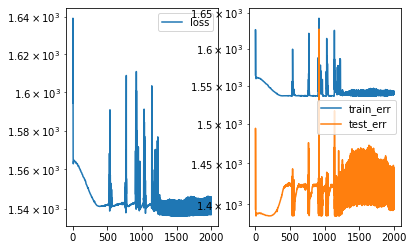

In [19]:
fig, axs = plt.subplots(1,2)
axs[0].plot(range(1,EPOCHS+1), losses, label="loss")
axs[1].plot(range(1,EPOCHS+1), train_err_list, label="train_err")
axs[1].plot(range(1,EPOCHS+1), test_err_list, label="test_err")

for ax in axs:
    ax.set_yscale("log")
    ax.legend()